<a href="https://colab.research.google.com/github/SergeySkopin/SergeyS_pet/blob/master/CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision import transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform
from torchvision.models import resnet50, ResNet50_Weights

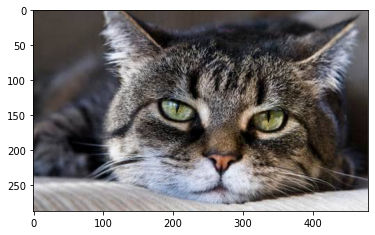

In [ ]:
#Загружаем свое изображение
image = Image.open("cat.jpg")
imshow(image)

In [ ]:
# Препроцессим и нормализуем дату
norm_data = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   norm_data
])

display = transforms.Compose([transforms.Resize((224,224))])
tensor = preprocess(image)
pred = Variable((tensor.unsqueeze(0)), requires_grad=False)

In [ ]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.eval()

#Класс Hook можно подсмотреть в реализации fast.ai
class Hook():
    def __init__(self, m): 
      self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self, module, input, output):
      self.features = ((output.cpu()).data).numpy()
    def remove(self):
      self.hook.remove()

#Получаем карты активации с последнего сверточного слоя
final_layer = model._modules.get('layer4')
act_maps = Hook(final_layer)

#Прогоняем нашу картинку через модель и затем удаляем hook, дабы избежать утечки памяти
prediction = model(pred)
pred_prob = F.softmax(prediction, -1).data.squeeze()
act_maps.remove()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#Оцениваем какой вклад сделали наши карты признаков
def CAM(out_feature_conv, sum_weight, class_idx):
    _, nc, h, w = out_feature_conv.shape
    imp = sum_weight[idx].dot(out_feature_conv.reshape((nc, h*w))).reshape(h, w)
    cam = imp - np.min(imp)
    cam = cam / np.max(cam)
    return [cam]
    
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
idx = topk(pred_prob,1)[1].int()
overlay = CAM(act_maps.features, weight_softmax, idx )



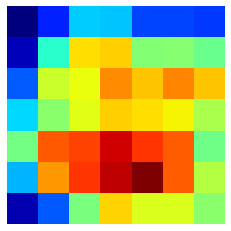

In [ ]:
plt.axis('off')
imshow(overlay[0], alpha=1, cmap='jet')

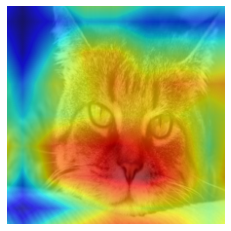

In [ ]:
imshow(display(image))
plt.axis('off')
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.7, cmap='jet');